In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from statannotations.Annotator import Annotator
from biodatatools.utils.common import json_load
from biodata.delimited import DelimitedReader
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats import multitest
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Venn diagram

In [4]:
ps = ["divergent", "unidirectional"]

In [5]:
genes = json_load(f"{PROJECT_DIR_o}ABC/K562/procap_genes.json")

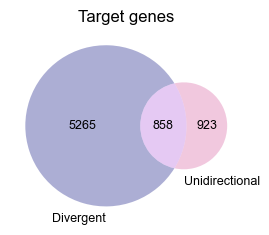

In [6]:
fig, ax = plt.subplots(figsize=(3,3))
subsets = [set(genes[k]) | set(genes["Shared"]) for k in genes if k != "Shared"]
set_labels = tuple([p.capitalize() for p in ps])
g = venn2(subsets=subsets, set_labels=set_labels, set_colors=["#313695", "#de77ae"], ax=ax)
for text in g.set_labels:
	text.set_fontsize(sfontsize)
for text in g.subset_labels:
	text.set_fontsize(sfontsize)
plt.title("Target genes", fontsize=bfontsize)
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig7b.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)

# LOEUF

In [7]:
# LOEUF is a conservative estimate of the observed/expected ratio, based on the upper bound of a Poisson-derived confidence interval around the ratio. Low LOEUF scores indicate strong selection against predicted LoF variation in a given gene, while high LOEUF scores suggest a relatively higher tolerance to inactivation. They suggest using a LOEUF score < 0.6 as a threshold if needed. Ideally LOEUF should be used as a continuous value rather than a cutoff.
# One advantage of LOEUF compared to pLI are that they are more direct measures of biological significance, and can be easily used as continuous values.

inputfile = f"{PROJECT_DIR_r}other/gnomad/gnomad.v4.1.constraint_metrics.tsv"
df = pd.read_table(inputfile)
df.head(2)

,gene,gene_id,transcript,canonical,mane_select,lof_hc_lc.obs,lof_hc_lc.exp,lof_hc_lc.possible,lof_hc_lc.oe,lof_hc_lc.mu,...,syn.oe_ci.lower,syn.oe_ci.upper,syn.z_raw,syn.z_score,constraint_flags,level,transcript_type,chromosome,cds_length,num_coding_exons
0,A1BG,1,NM_130786.4,True,True,45.0,43.048,193.0,1.0454,7.063300e-07,...,0.973,1.172,-1.166,-0.63549,[],NaN,NaN,NaN,NaN,NaN
1,A1BG,ENSG00000121410,ENST00000263100,True,True,45.0,43.048,193.0,1.0454,7.063300e-07,...,0.973,1.172,-1.166,-0.63549,[],2.0,protein_coding,chr19,1485.0,8.0


In [8]:
scores = {}
for index, row in df.iterrows():
	if row["canonical"] and row["mane_select"]:
		scores[row["gene"]] = row["lof.oe_ci.upper"]

In [9]:
results = []
for k in genes:
	for g in genes[k]:
		if g in scores:
			results.append([k.capitalize(), scores[g]])
df_loeuf = pd.DataFrame(results, columns=["group", "score"])

In [10]:
order = ["Shared", "Divergent", "Unidirectional"]
palette = ["#969696", "#313695", "#de77ae"]
pairs = [["Shared", "Divergent"], ["Divergent", "Unidirectional"]]

In [11]:
def boxplot(df, ylabel, outputfile, figsize):
	fig, ax = plt.subplots(figsize=figsize)
	hue_plot_params = {
					"data": df,
					"x": "group",
					"y": "score",
				    "palette": palette,
					"hue": "group",
					"legend": False,
					"order": order,
					"showfliers": False
				}
	g = sns.boxplot(ax=ax, **hue_plot_params)
	g.spines[["right", "top"]].set_visible(False)

	g.set_ylabel(ylabel, fontsize=bfontsize)
	g.tick_params(axis='y', labelsize=sfontsize)
	
	g.set_xlabel("")
	g.tick_params(axis='x', rotation=30, labelsize=bfontsize)

	annotator = Annotator(g, pairs, **hue_plot_params)
	annotator.configure(test="Mann-Whitney", comparisons_correction="BH", text_offset=1, text_format="star", verbose=False, loc="outside")
	_, results = annotator.apply_and_annotate()
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

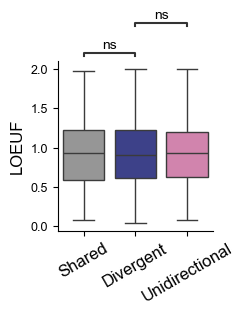

In [12]:
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig7c.pdf"
boxplot(df_loeuf, "LOEUF", outputfile, (2,2.2))

# Gene expression

In [13]:
inputfile = f"{PROJECT_DIR_r}ENCODE/K562.ENCFF934YBO.TPM.txt"
df = pd.read_table(inputfile, header=None)
df.head(2)

,0,1
0,TSPAN6,0.03
1,TNMD,0.00


In [14]:
exps = {}
for index, row in df.iterrows():
	exps[row[0]] = row[1]

In [15]:
results = []
for k in genes:
	for g in genes[k]:
		if g in exps:
			results.append([k.capitalize(), np.log2(exps[g]+1)])
df_exps = pd.DataFrame(results, columns=["group", "score"])

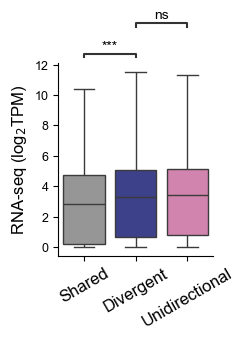

In [16]:
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig7d.pdf"
boxplot(df_exps, "RNA-seq (log$_2$TPM)", outputfile, (2,2.5))

# P1 vs. P2

In [17]:
inputfile = f"{PROJECT_DIR_r}other/PM35594906/41586_2022_4877_MOESM9_ESM.txt"
results = []
with DelimitedReader(inputfile) as dr:
	for cols in dr:
		if "#" not in cols[0]:
			results.append(cols)
df = pd.DataFrame(results)
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)
df.head(2)

,GeneSymbol,start,end,predictedClass,predictedScore,activity_base.500bp
0,A2ML1,8997356,8997620,2,0.37797089308516196,0.874977
1,A4GALT,43117286,43117550,2,1.0479697839633664,0.257458


In [18]:
types = {}
for n in range(2):
	types["P"+str(n+1)] = list(df[df["predictedClass"]==str(n+1)]["GeneSymbol"])
	print("P"+str(n+1), len(types["P"+str(n+1)]))

P1 7872
P2 8092


In [19]:
results = []
for k in order:
	# with prediction available
	tot = sum([1 for g in genes[k] if g in types["P1"] or g in types["P2"]])
	p2 = sum([1 for g in genes[k] if g in types["P2"]])
	results.append([k, tot, p2, round(100*p2/tot,1)])
df_prop = pd.DataFrame(results, columns=["group", "total", "P2", "ratio"])
df_prop

,group,total,P2,ratio
0,Shared,746,293,39.3
1,Divergent,4658,2209,47.4
2,Unidirectional,823,446,54.2


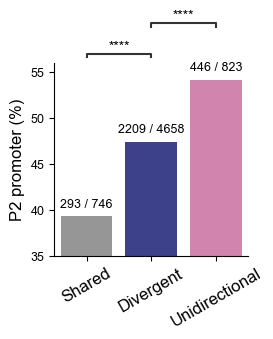

In [20]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
hue_plot_params = {
				"data": df_prop,
				"x": "group",
				"y": "ratio",
				"palette": palette,
				"hue": "group",
				"legend": False,
				"order": order
			}
g = sns.barplot(ax=ax, **hue_plot_params)
g.spines[["right", "top"]].set_visible(False)

g.set_ylabel("P2 promoter (%)", fontsize=bfontsize)
g.tick_params(axis='y', labelsize=sfontsize)

g.set_xlabel("")
g.tick_params(axis='x', rotation=30, labelsize=bfontsize)

texts = []
for index, row in df_prop.iterrows():
	texts.append(str(row["P2"])+" / "+str(row["total"]))

for bar, text in zip(g.patches, texts):
	g.text(bar.get_x()+0.4, bar.get_height()+1, text, color="#000000", ha="center", fontsize=sfontsize) 
g.set_ylim([35, 56])

pvalues = []
successes = df_prop["P2"]
nobs = df_prop["total"]
for x1, x2 in [[0,1],[0,2]]:
	pvalues.append(proportions_ztest([successes[x1], successes[x2]], [nobs[x1], nobs[x2]])[1])
_, qvalues, _, _ = multitest.multipletests(pvalues, alpha=0.05, method='fdr_bh')
annotator = Annotator(g, pairs, **hue_plot_params)
annotator.configure(text_format="star", verbose=False, text_offset=1, loc="outside")
annotator.set_pvalues(qvalues).annotate()		

outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig7e.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)